In [2]:
import tonic
import tonic.transforms as transforms
from tonic import DiskCachedDataset

import torch
import torchvision
from torch.utils.data import DataLoader


import snntorch as snn
from snntorch import surrogate
from snntorch import functional as SF
from snntorch import spikeplot as splt
from snntorch import utils
import torch.nn as nn

import matplotlib.pyplot as plt

from IPython.display import HTML

In [3]:
# Import neuromorphic mnist dataset

dataset = tonic.datasets.NMNIST(save_to = './data', train = True)
events, targets = dataset[0]

  0%|          | 0/1011893601 [00:00<?, ?it/s]

Extracting ./data/NMNIST/train.zip to ./data/NMNIST


In [13]:
print(events) # Each row is (x-coord, y-coord, timestamp(uS), polarity(+1, -1))

[( 0, 30,   1213, 1) ( 9, 18,   4044, 0) (30, 15,   4104, 1) ...
 ( 9, 17, 301658, 0) (18,  8, 305112, 1) (19, 26, 309976, 1)]


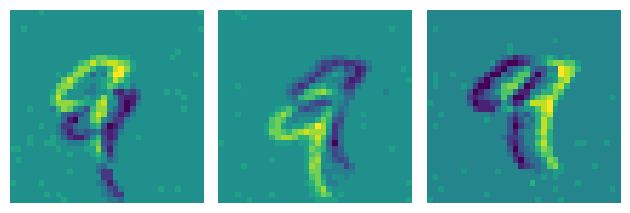

In [22]:
tonic.utils.plot_event_grid(events)

# Transforming NMNIST

Need to convert list of events from sensor into a tensor representation. As the sensor (in this case, an event camera) has microsecond temporal resolution, this will be a huge tensor. We can overcome this constraint by binning events into a smaller number of frames - uses the Tonic ToFrame transform - which can result in a slight loss of temporal precision but allows us to work with the data in a dense format.

In [17]:
sensor_size = tonic.datasets.NMNIST.sensor_size

frame_transform = transforms.Compose([transforms.Denoise(filter_time = 10000), # Removes isolated, one-off events (smaller value filters more events)
                                     transforms.ToFrame(sensor_size = sensor_size,
                                     time_window = 1000) # Integrates events into 1000uS bins
                                     ]) 
trainset = tonic.datasets.NMNIST(save_to = './data', transform = frame_transform, train = True)
testset = tonic.datasets.NMNIST(save_to = './data', transform = frame_transform, train = False)

  0%|          | 0/169674850 [00:00<?, ?it/s]

Extracting ./data/NMNIST/test.zip to ./data/NMNIST


In [18]:
# Caching dataset to speed up dataloading

cached_trainset = DiskCachedDataset(trainset, cache_path = './cache/nmnist/train')
cached_dataloader = DataLoader(cached_trainset)

batch_size = 128

# Collation is necessary -> event recordings have different lengths, so tensors will need to be padded to have consistent dims
trainloader = DataLoader(cached_trainset, batch_size = batch_size, collate_fn = tonic.collation.PadTensors())

In [19]:
def load_sample_batched():
    events, target = next(iter(cached_dataloader))

In [20]:
%timeit -o -r 10 load_sample_batched()

2.93 ms ± 14.6 µs per loop (mean ± std. dev. of 10 runs, 100 loops each)


<TimeitResult : 2.93 ms ± 14.6 µs per loop (mean ± std. dev. of 10 runs, 100 loops each)>

Note that I was using an M1 Macbook Air. If I had sufficient RAM, I could have cached to memory instead of disk using:

from tonic import MemoryCachedDataset
cached_trainset = MemoryCachedDataset(trainset)

# Training a NN Using Frames Created From Events

In [23]:
transform = tonic.transforms.Compose([torch.from_numpy,
                                     torchvision.transforms.RandomRotation([-10, 10])]) # Since we're dealing with frames, we can use torchvision transforms & augmentations

cached_trainset = DiskCachedDataset(trainset, transform = transform, cache_path = './cache/nmnist/train')

# Not applying transforms to test set
cached_testset = DiskCachedDataset(testset, cache_path = './cache/nmnist/test')

batch_size = 128

trainloader = DataLoader(cached_trainset, batch_size = batch_size, collate_fn = tonic.collation.PadTensors(batch_first = False), shuffle = True)
testloader = DataLoader(cached_testset, batch_size = batch_size, collate_fn = tonic.collation.PadTensors(batch_first = False))

In [24]:
event_tensor, target = next(iter(trainloader))
print(event_tensor.shape) # Number of time steps in longest recording in minibatch, batch size, polarity, dimensions

torch.Size([309, 128, 2, 34, 34])


For the network, I'll be using the 12C5-MP2-32C5-MP2-800FC10 architecture, which corresponds to the use of:
- 12C5: 5x5 convolutional kernel with 12 filters
- MP2: 2x2 max-pooling function
- 200FC10: a fully-connected layer which maps 800 neurons to 10 outputs

In [25]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# Simulation parameters
spike_grad = surrogate.atan()
beta = 0.5

net = nn.Sequential(nn.Conv2d(2, 12, 5),
                   nn.MaxPool2d(2),
                   snn.Leaky(beta = beta, spike_grad = spike_grad, init_hidden = True),
                   nn.Conv2d(12, 32, 5),
                   nn.MaxPool2d(2),
                   snn.Leaky(beta = beta, spike_grad = spike_grad, init_hidden = True),
                   nn.Flatten(),
                   nn.Linear(32 * 5 * 5, 10),
                   snn.Leaky(beta = beta, spike_grad = spike_grad, init_hidden = True, output = True)
                   ).to(device)

In [26]:
def forward_pass(net, data):
    spk_rec = []
    utils.reset(net) # Resets hidden states for all LIF neurons in the net
    
    for step in range(data.size(0)):
        spk_out, mem_out = net(data[step])
        spk_rec.append(spk_out)

    return torch.stack(spk_rec)

In [27]:
optimizer = torch.optim.Adam(net.parameters(), lr = 2e-2, betas = (0.9, 0.999))

loss_fn = SF.mse_count_loss(correct_rate = 0.8, incorrect_rate = 0.2) # Helps avoid the dead neuron problem by encouraging incorrect neurons to spike 20% of the time

# Use Cross Entropy Loss if the goal is to maximize the number of spikes from the correct class

In [29]:
num_epochs = 1
num_iters = 50

loss_hist = []
acc_hist = []

for epoch in range(num_epochs):
    for i, (data, targets) in enumerate(iter(trainloader)):
        data = data.to(device)
        targets = targets.to(device)
        
        net.train()
        spk_rec = forward_pass(net, data)
        loss_val = loss_fn(spk_rec, targets)
        
        optimizer.zero_grad()
        loss_val.backward()
        optimizer.step()
        
        loss_hist.append(loss_val.item())
        
        print(f'Epoch {epoch}, Iteration {i} \nTrain Loss: {loss_val.item():.2f}')

        acc = SF.accuracy_rate(spk_rec, targets)
        acc_hist.append(acc)
        print(f'Accuracy: {acc * 100:.2f}%\n')

        if i == num_iters:
            break

Epoch 0, Iteration 0 
Train Loss: 31.00
Accuracy: 7.81%

Epoch 0, Iteration 1 
Train Loss: 30.90
Accuracy: 7.81%

Epoch 0, Iteration 2 
Train Loss: 31.00
Accuracy: 10.16%

Epoch 0, Iteration 3 
Train Loss: 30.90
Accuracy: 10.94%

Epoch 0, Iteration 4 
Train Loss: 28.67
Accuracy: 10.16%

Epoch 0, Iteration 5 
Train Loss: 14.03
Accuracy: 8.59%

Epoch 0, Iteration 6 
Train Loss: 16.67
Accuracy: 11.72%

Epoch 0, Iteration 7 
Train Loss: 18.51
Accuracy: 7.03%

Epoch 0, Iteration 8 
Train Loss: 19.05
Accuracy: 14.06%

Epoch 0, Iteration 9 
Train Loss: 16.44
Accuracy: 9.38%

Epoch 0, Iteration 10 
Train Loss: 13.65
Accuracy: 18.75%

Epoch 0, Iteration 11 
Train Loss: 12.78
Accuracy: 16.41%

Epoch 0, Iteration 12 
Train Loss: 16.49
Accuracy: 17.19%

Epoch 0, Iteration 13 
Train Loss: 14.34
Accuracy: 15.62%

Epoch 0, Iteration 14 
Train Loss: 12.18
Accuracy: 8.59%

Epoch 0, Iteration 15 
Train Loss: 12.88
Accuracy: 15.62%

Epoch 0, Iteration 16 
Train Loss: 13.70
Accuracy: 13.28%

Epoch 0, Iter

# Interpreting Results

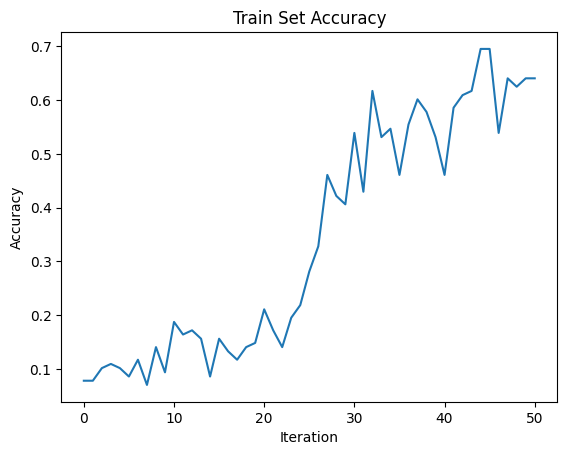

In [30]:
fig = plt.figure(facecolor = 'w')
plt.plot(acc_hist)
plt.title('Train Set Accuracy')
plt.xlabel('Iteration')
plt.ylabel("Accuracy")
plt.show()

In [31]:
spk_rec = forward_pass(net, data)

The target label is: 9


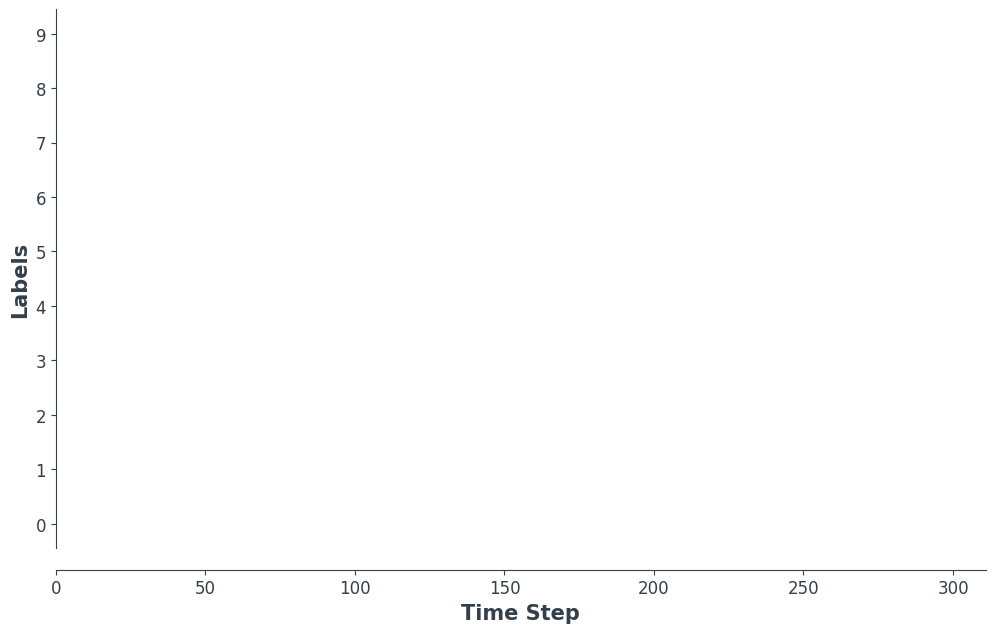

In [33]:
idx = 1

fig, ax = plt.subplots(facecolor = 'w', figsize = (12, 7))
labels = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
print(f'The target label is: {targets[idx]}')

plt.rcParams['animation.ffmpeg_path'] = '/opt/homebrew/bin/ffmpeg'

anim = splt.spike_count(spk_rec[:, idx].detach().cpu(),
                       fig,
                       ax,
                       labels = labels,
                       animate = True,
                       interpolate = 1)
HTML(anim.to_html5_video())